<img src="Ufo-icon.png" height="256" width="256" style="float: right">

# A Needle in a Data Haystack - Final Project
## Matan Cohen, Nir Schipper & Ran Shaham
### Exploring UFO sightings data (or - ARE ALIENS REAL?)

### Initialization

In [1]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import html
from ipywidgets import interact

In [2]:
# constants
FILENAME = 'scrubbed.csv'
DATETIME = 'datetime'
YEAR = 'year'
MONTH = 'month'
DAY = 'day'
TIME = 'time'
SHAPE = 'shape'
DESCRIPTION = 'comments'

DATE_FORMAT = '%m/%d/%Y %H:%M'
FIX_TIME_REGEX = (r'\s24:(\d{2})\s*$', r' 00:\1')

In [3]:
# magic & settings
%matplotlib inline
# big, juicy plots
sns.set_context('talk')
LARGE_FIGSIZE = (12, 8)
# style
sns.set_style(style='white', rc={'figsize': LARGE_FIGSIZE})
plt.rcParams.update({
    'figure.figsize': LARGE_FIGSIZE,
})

### Read & Clean the dataset

In [4]:
# read the csv file and display some of its lines
data = pd.read_csv(FILENAME, low_memory=False)

# make comments readable (unescape html)
data.loc[:, DESCRIPTION] = data[DESCRIPTION].apply(lambda val: html.unescape(str(val)))

# parse datetime - fix 24h format first (24:xx --> 00:xx)
# and insert a year column
data.loc[:, DATETIME] = data[DATETIME].apply(lambda val: re.sub(*FIX_TIME_REGEX, str(val)))
data.loc[:, DATETIME] = pd.to_datetime(data[DATETIME], errors='coerce')
data.insert(1, YEAR, data[DATETIME].dt.year)
data.loc[:, YEAR] = data[YEAR].fillna(0).astype(int)

# tidy up the rest of the columns
data.loc[:, 'city'] = data['city'].str.title()
for col in ['state', 'country']:
    data.loc[:, col] = data[col].str.upper()
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data = data.rename(columns={'longitude ':'longitude'})

data.head()

,datetime,year,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,1949,San Marcos,TX,US,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,1949-10-10 21:00:00,1949,Lackland Afb,TX,NaN,light,7200,1-2 hrs,"1949 Lackland AFB, TX. Lights racing across t...",12/16/2005,29.384210,-98.581082
2,1955-10-10 17:00:00,1955,Chester (Uk/England),NaN,GB,circle,20,20 seconds,"Green/Orange circular disc over Chester, England",1/21/2008,53.200000,-2.916667
3,1956-10-10 21:00:00,1956,Edna,TX,US,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,1960-10-10 20:00:00,1960,Kaneohe,HI,US,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611


### Shapes analysis

First, we extract the unique shape values from all sightings:

In [5]:
shapes = pd.unique(data[SHAPE])
shapes = [shape for shape in shapes if not pd.isnull(shape)]

... and for every year, get the proportion of sightings with a given shape:

In [6]:
# get the distribution of each shape for every year
years = np.unique(data[YEAR])
def get_shape_distribution(shape, data):
    # ignore queries with a small number of data rows
    if len(data) < 10:
        return 0
    else:
        return len(data.loc[data[SHAPE] == shape, SHAPE]) / len(data)

shapes_dist = pd.DataFrame(columns=shapes, index=years)
for year in years:
    year_data = data.loc[data[YEAR] == year, :]
    shapes_distributions = {shape: get_shape_distribution(shape, year_data)
                            for shape in shapes}
    shapes_dist.loc[year, :] = shapes_distributions

Use the following widget to explore the change in shapes in sightings over the years

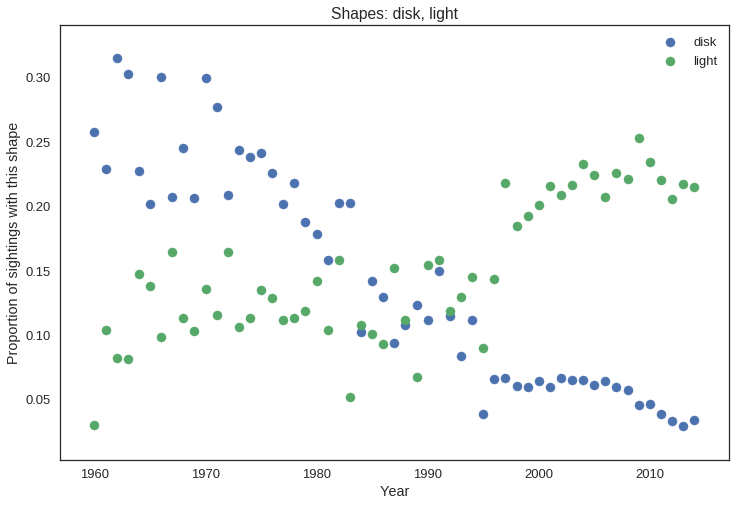

In [7]:
shapes_selection = {shape: False for shape in shapes}

@interact(from_time=[min(years), max(years)],
          to_time=[min(years), max(years)],
          shape_1=shapes, 
          shape_2=shapes)
def plot_shape_distributions(from_time=1960,
                             to_time=2014,
                             shape_1='disk', 
                             shape_2='light'):
    # configure the figure
    fig = plt.figure()
    plt.xlabel('Year')
    plt.ylabel('Proportion of sightings with this shape')
    plt.title("Shapes: {0}, {1}".format(shape_1, shape_2))
    
    # get the relevant data and plot it
    to_time = max(from_time, to_time)
    x_0 = years[(years >= from_time) & (years <= to_time)]
    ys = [None, None]
    ys[0] = shapes_dist.loc[x_0, shape_1]
    ys[1] = shapes_dist.loc[x_0, shape_2]
    for y in ys:
        # we ignore years with 0 sightings
        y = y.replace(0, np.nan).dropna()
        x = [year for year in x_0 if year in y.index]
        plt.scatter(x, y)

    plt.legend()

_We get a lot less disk-shaped UFOs these days. What a shame._

### Sighting's Duration Analysis

### Locations Analysis